# Project 2: Adversarial Search in AI 
## Applying Kalman Filters for Airplane Tracking 

# Import Statements

In [580]:
from project2_base import *
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import traffic
from pykalman import KalmanFilter
from datetime import timedelta
from geopy import distance as dist
from geopy.distance import geodesic
from copy import deepcopy
import warnings

In [581]:
# warnings.filterwarnings("ignore")

# Data Loading and Initial Exploration

In [582]:
# Load the data
datas = get_ground_truth_data()
print(datas)
print(type(datas))

# Extract a list of flight IDs and store it as a variable called flight_ids
flight_ids = list(datas.keys())
print(flight_ids)


reading data of flight: IGRAD_000
ERROR: duplicate flight ids: IGRAD_000
reading data of flight: IGRAD_000
reading data of flight: PXR31F_001
ERROR: duplicate flight ids: PXR31F_001
reading data of flight: PXR31F_001
reading data of flight: N441FS_002
ERROR: duplicate flight ids: N441FS_002
reading data of flight: N441FS_002
reading data of flight: N441FS_003
ERROR: duplicate flight ids: N441FS_003
reading data of flight: N441FS_003
reading data of flight: OKVOK_004
ERROR: duplicate flight ids: OKVOK_004
reading data of flight: OKVOK_004
reading data of flight: FGALN_005
ERROR: duplicate flight ids: FGALN_005
reading data of flight: FGALN_005
reading data of flight: FGALN_006
ERROR: duplicate flight ids: FGALN_006
reading data of flight: FGALN_006
reading data of flight: HAYCG_007
ERROR: duplicate flight ids: HAYCG_007
reading data of flight: HAYCG_007
reading data of flight: FGALN_008
ERROR: duplicate flight ids: FGALN_008
reading data of flight: FGALN_008
reading data of flight: FAF4

Generate radar data for all flights in the dataset

In [583]:
radar_flights = get_radar_data(datas) 
print(radar_flights)

flight: IGRAD_000
flight: PXR31F_001
flight: N441FS_002
flight: N441FS_003
flight: OKVOK_004
flight: FGALN_005
flight: FGALN_006
flight: HAYCG_007
flight: FGALN_008
flight: FAF4011_009
flight: PSWRD35_010
flight: F-CHDN_011
flight: D-KRPK_012
flight: D-6567_013
flight: SS_014
flight: F-CIJO_015
flight: G-CLPU_016
flight: D-KWFW_017
flight: REGA1_018
flight: SAMU31_019
flight: REGA1_020
flight: CALIBRA_021
flight: YS111N_022
flight: VOR05_023
flight: GTACN_024
flight: ADA4_025
flight: CALIBRA_026
flight: CALIBRA_027
flight: CALIBRA_028
flight: CALIBRA_029
flight: GTACN_030
flight: ADA4_031
flight: 9MFCL_032
flight: NVC201_033
flight: VOR05_034
flight: CALIBRA_035
flight: FCK211_036
flight: NVC103_037
flight: VOR05_038
flight: CALIBRA_039
flight: CFL12_040
flight: CFL12_041
flight: YS111N_042
flight: CALIBRA_043
flight: FCK211_044
flight: GTEKV_045
flight: BOE004_046
flight: N56821_047
flight: ZEROG_048
flight: QFA7474_049
flight: THY1920_050
flight: AIB232E_051
flight: DMUPY_052
flight:

### Analyse the first flight  

In [584]:
datas["IGRAD_000"]
print (type(datas["IGRAD_000"]))

<class 'traffic.core.flight.Flight'>


In [585]:
dict(datas["IGRAD_000"])

{'flight_id': 'IGRAD_000',
 'callsign': 'IGRAD',
 'icao24': '3006bd',
 'aircraft': Tail(icao24='3006bd', registration='I-GRAD', typecode='P68', flag='🇮🇹'),
 'start': Timestamp('2020-04-15 07:39:00+0000', tz='UTC'),
 'stop': Timestamp('2020-04-15 11:51:30+0000', tz='UTC'),
 'duration': Timedelta('0 days 04:12:30')}

In [586]:
datas["IGRAD_000"].data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,squawk,altitude,flight_id
0,2020-04-15 07:39:00+00:00,3006bd,44.362427,8.699668,106.0,234.0,128.0,IGRAD,0,1300.0,IGRAD_000
1,2020-04-15 07:39:10+00:00,3006bd,44.359535,8.694004,111.0,234.0,-64.0,IGRAD,0,1275.0,IGRAD_000
2,2020-04-15 07:39:20+00:00,3006bd,44.356659,8.687897,109.0,239.0,0.0,IGRAD,0,1275.0,IGRAD_000
3,2020-04-15 07:39:30+00:00,3006bd,44.351807,8.678462,109.0,230.0,384.0,IGRAD,0,1275.0,IGRAD_000
4,2020-04-15 07:39:40+00:00,3006bd,44.348503,8.673103,104.0,229.0,768.0,IGRAD,4201,1375.0,IGRAD_000
...,...,...,...,...,...,...,...,...,...,...,...
1511,2020-04-15 11:50:50+00:00,3006bd,44.393284,8.869719,89.0,14.0,-1024.0,IGRAD,4201,525.0,IGRAD_000
1512,2020-04-15 11:51:00+00:00,3006bd,44.397491,8.871264,84.0,17.0,-576.0,IGRAD,4201,350.0,IGRAD_000
1513,2020-04-15 11:51:10+00:00,3006bd,44.403214,8.872637,74.0,7.0,-576.0,IGRAD,4201,250.0,IGRAD_000
1514,2020-04-15 11:51:20+00:00,3006bd,44.404781,8.871593,71.0,318.0,-832.0,IGRAD,4201,200.0,IGRAD_000


In [587]:
print(type(datas["IGRAD_000"].data))

<class 'pandas.core.frame.DataFrame'>


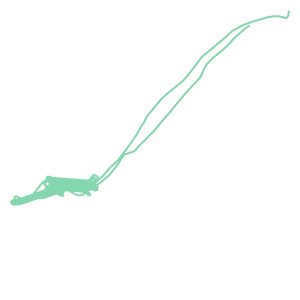

In [588]:
datas["IGRAD_000"].between("2020-04-15 07:00", "2020-04-15 12:00")

In [589]:
datas["IGRAD_000"].between("2020-04-15 07:00", "2020-04-15 12:00").data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,squawk,altitude,flight_id
0,2020-04-15 07:39:00+00:00,3006bd,44.362427,8.699668,106.0,234.0,128.0,IGRAD,0,1300.0,IGRAD_000
1,2020-04-15 07:39:10+00:00,3006bd,44.359535,8.694004,111.0,234.0,-64.0,IGRAD,0,1275.0,IGRAD_000
2,2020-04-15 07:39:20+00:00,3006bd,44.356659,8.687897,109.0,239.0,0.0,IGRAD,0,1275.0,IGRAD_000
3,2020-04-15 07:39:30+00:00,3006bd,44.351807,8.678462,109.0,230.0,384.0,IGRAD,0,1275.0,IGRAD_000
4,2020-04-15 07:39:40+00:00,3006bd,44.348503,8.673103,104.0,229.0,768.0,IGRAD,4201,1375.0,IGRAD_000
...,...,...,...,...,...,...,...,...,...,...,...
1511,2020-04-15 11:50:50+00:00,3006bd,44.393284,8.869719,89.0,14.0,-1024.0,IGRAD,4201,525.0,IGRAD_000
1512,2020-04-15 11:51:00+00:00,3006bd,44.397491,8.871264,84.0,17.0,-576.0,IGRAD,4201,350.0,IGRAD_000
1513,2020-04-15 11:51:10+00:00,3006bd,44.403214,8.872637,74.0,7.0,-576.0,IGRAD,4201,250.0,IGRAD_000
1514,2020-04-15 11:51:20+00:00,3006bd,44.404781,8.871593,71.0,318.0,-832.0,IGRAD,4201,200.0,IGRAD_000


# Data Analysis

### Helper functions to calculate duration of flight, altitude, and flight complexity


In [590]:
def calculate_duration(flight_data):
    """
    Calculates the duration of the flight
    
    Args:
        flight_data (pandas.DataFrame): The flight data containing 'timestamp' column.
    
    Returns:
        pandas.Timedelta: The duration of the flight.
    """
    duration = flight_data['timestamp'].max() - flight_data['timestamp'].min()
    return duration

In [591]:
def analyze_altitude(flight_data):
    """
    Analyzes the altitude data of the flight.
    
    Args:
        flight_data (pandas.DataFrame): The flight data containing 'altitude' column.
    
    Returns:
        dict: A dictionary containing max, min, and average altitude.
    """
    max_altitude = flight_data['altitude'].max()
    min_altitude = flight_data['altitude'].min()
    avg_altitude = flight_data['altitude'].mean()
    
    return {'max_altitude': max_altitude, 'min_altitude': min_altitude, 'avg_altitude': avg_altitude}

In [592]:
def estimate_route_complexity(flight_data, change_threshold=20):
    """
    Estimates the route complexity by counting the number of significant directional changes.
    
    Args:
        flight_data (pandas.DataFrame): The flight data containing 'latitude' and 'longitude' columns.
        change_threshold (int): The change in bearing considered significant, in degrees.
    
    Returns:
        int: The estimated route complexity, defined by the number of significant turns.
    """
    num_turns = 0
    last_bearing = None
    
    for i in range(1, len(flight_data)):
        prev_point = (flight_data.iloc[i - 1]['latitude'], flight_data.iloc[i - 1]['longitude'])
        current_point = (flight_data.iloc[i]['latitude'], flight_data.iloc[i]['longitude'])
        
        # Calculate bearing between consecutive points
        delta_lon = np.radians(current_point[1] - prev_point[1])
        y = np.sin(delta_lon) * np.cos(np.radians(current_point[0]))
        x = np.cos(np.radians(prev_point[0])) * np.sin(np.radians(current_point[0])) - \
            np.sin(np.radians(prev_point[0])) * np.cos(np.radians(current_point[0])) * np.cos(delta_lon)
        current_bearing = np.degrees(np.arctan2(y, x)) % 360
        
        if last_bearing is not None:
            bearing_change = abs(current_bearing - last_bearing)
            bearing_change = min(bearing_change, 360 - bearing_change)  # Correct for angular wraparound
            if bearing_change > change_threshold:
                num_turns += 1
        
        last_bearing = current_bearing
    
    return num_turns

### Anaylse Duration, Altitude, and Route Complexity for each flight

In [593]:
# Initialize a dictionary to store the results
results = {}

# Iterating through each flight in the dataset
for flight_id, flight in datas.items():
    
    # Access the DataFrame directly
    flight_data = flight.data  # Since it's already a DataFrame
    
    # Ensure the DataFrame is not empty
    if not flight_data.empty:
        # Calculate flight duration
        duration = calculate_duration(flight_data)

        # Analyze altitude data
        altitude_info = analyze_altitude(flight_data)

        # Estimate route complexity
        complexity = estimate_route_complexity(flight_data)  # Make sure this function is defined and adapted to your data structure

        # Store the results for the current flight
        results[flight_id] = {
            'duration': duration,
            'max_altitude': altitude_info['max_altitude'],
            'min_altitude': altitude_info['min_altitude'],
            'avg_altitude': altitude_info['avg_altitude'],
            'route_complexity': complexity
        }
    else:
        print(f"Warning: No data available for flight {flight_id}")

# Print out the results for each flight
for flight_id, metrics in results.items():
    print(f"Flight ID: {flight_id}")
    print(f"Duration: {metrics['duration']}")
    print(f"Max Altitude: {metrics['max_altitude']} meters")
    print(f"Min Altitude: {metrics['min_altitude']} meters")
    print(f"Average Altitude: {metrics['avg_altitude']} meters")
    print(f"Route Complexity (number of significant turns): {metrics['route_complexity']}")
    print("---------------------------------------------------------")

Flight ID: IGRAD_000
Duration: 0 days 04:12:30
Max Altitude: 4250.0 meters
Min Altitude: 100.0 meters
Average Altitude: 3251.500659630607 meters
Route Complexity (number of significant turns): 183
---------------------------------------------------------
Flight ID: PXR31F_001
Duration: 0 days 04:40:30
Max Altitude: 4100 meters
Min Altitude: 1200 meters
Average Altitude: 3850.78834524464 meters
Route Complexity (number of significant turns): 350
---------------------------------------------------------
Flight ID: N441FS_002
Duration: 0 days 05:08:42
Max Altitude: 16200 meters
Min Altitude: 1300 meters
Average Altitude: 14419.602649006623 meters
Route Complexity (number of significant turns): 58
---------------------------------------------------------
Flight ID: N441FS_003
Duration: 0 days 04:35:15
Max Altitude: 16900 meters
Min Altitude: 1300 meters
Average Altitude: 15302.418207681365 meters
Route Complexity (number of significant turns): 52
-------------------------------------------

### Plot the graph

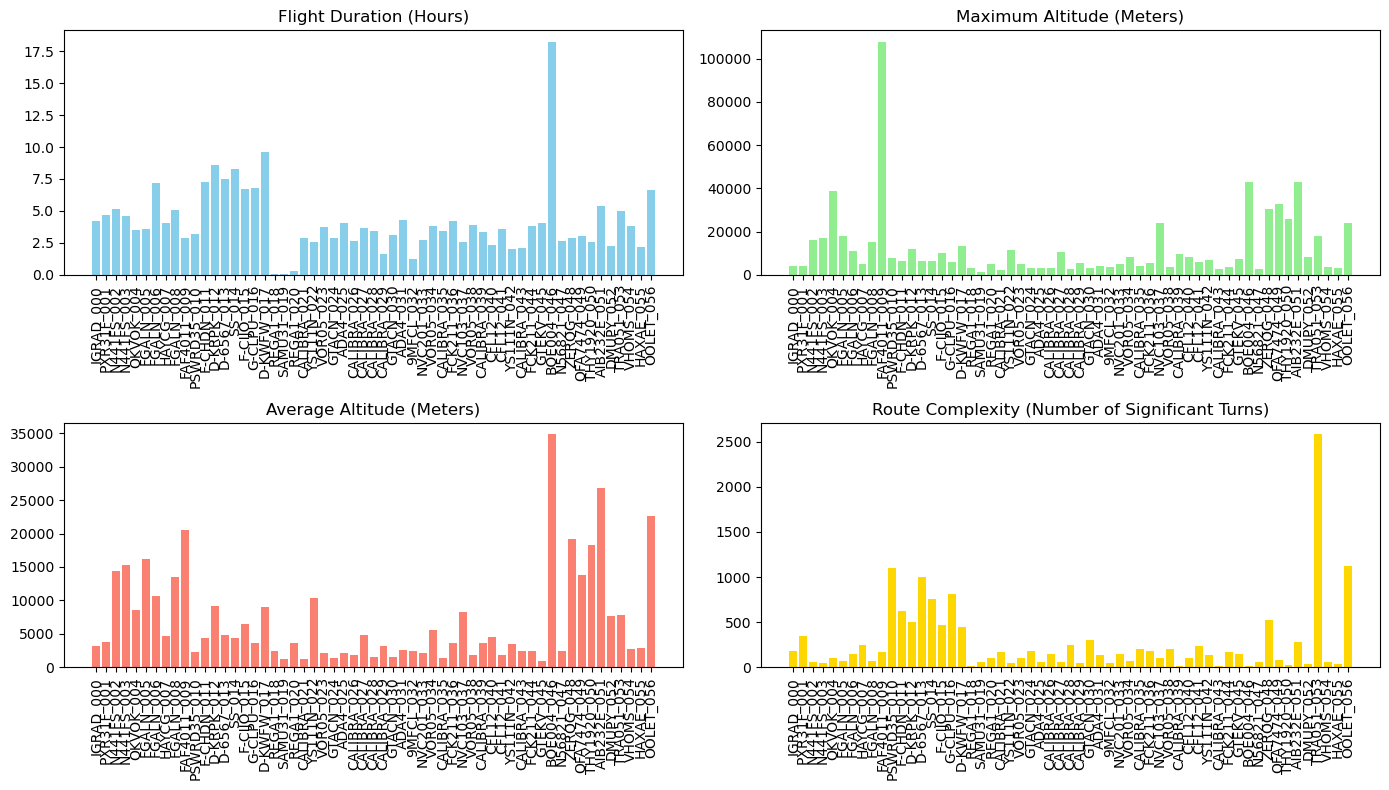

In [594]:
# Prepare lists for plotting
flight_ids = list(results.keys())
durations = [result['duration'].total_seconds()/3600 for result in results.values()]  # Convert duration to hours
max_altitudes = [result['max_altitude'] for result in results.values()]
min_altitudes = [result['min_altitude'] for result in results.values()]
avg_altitudes = [result['avg_altitude'] for result in results.values()]
route_complexities = [result['route_complexity'] for result in results.values()]

# Plotting
plt.figure(figsize=(14, 8))

# Plot for flight duration
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.bar(flight_ids, durations, color='skyblue')
plt.title('Flight Duration (Hours)')
plt.xticks(rotation=90)

# Plot for maximum altitude
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.bar(flight_ids, max_altitudes, color='lightgreen')
plt.title('Maximum Altitude (Meters)')
plt.xticks(rotation=90)

# Plot for average altitude
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
plt.bar(flight_ids, avg_altitudes, color='salmon')
plt.title('Average Altitude (Meters)')
plt.xticks(rotation=90)

# Plot for route complexity
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.bar(flight_ids, route_complexities, color='gold')
plt.title('Route Complexity (Number of Significant Turns)')
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Plot Functions

In [595]:
def plot_actual_radar_all(actual_data, radar_data, 
                          n_minor_ticks_x=0, n_minor_ticks_longitude=0, 
                          n_minor_ticks_latitude=0, 
                          actual_data_label_latitude='Latitude (Actual)', radar_data_label_latitude='Latitude (Radar)',
                          actual_data_label_longitude='Longitude (Actual)', radar_data_label_longitude='Longitude (Radar)'):
    """Plots a graph of longitude, latitude against time for both actual and radar flight data.

    Args:
        actual_data (panda.DataFrame): The actual data to be plotted
        radar_data (panda.DataFrame): The radar data to be plotted
        n_minor_ticks_x (integer): The number of minor axis intervals for time axis
        n_minor_ticks_longitude (integer): The number of minor axis intervals for longitude axis
        n_minor_ticks_latitude (integer): The number of minor axis intervals for latitude axis
        actual_data_label_latitude (string): Label for actual data (Latitude) 
        radar_data_label_latitude (string): Label for radar data (Latitude)
        actual_data_label_longitude (string): Label for actual data (Longitude) 
        radar_data_label_longitude (string): Label for radar data (Longitude) 
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Latitude', color='tab:red')
    ax1.plot(actual_data['timestamp'], actual_data['latitude'], color='tab:red', label=actual_data_label_latitude)
    ax1.plot(radar_data['timestamp'], radar_data['latitude'], color='tab:pink', label=radar_data_label_latitude, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for longitude
    ax2 = ax1.twinx()
    ax2.set_ylabel('Longitude', color='tab:blue')
    ax2.plot(actual_data['timestamp'], actual_data['longitude'], color='tab:blue', label=actual_data_label_longitude)
    ax2.plot(radar_data['timestamp'], radar_data['longitude'], color='tab:cyan', label=radar_data_label_longitude, linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add a title
    plt.title('Latitude and Longitude over Time')

    # Show legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set minor ticks between the major ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_latitude))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_longitude)) 

    # Color of the minor ticks
    ax1.tick_params(axis='y', which='minor', color='tab:red')
    ax2.tick_params(axis='y', which='minor', color='tab:blue')

    # Add vertical grid lines to the plot
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # Add horizontal grid lines to the plot for latitude
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    # Add horizontal grid lines to the plot for longitude
    ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:blue', alpha=0.5)

    plt.show()

In [596]:
def plot_actual_radar_latitude(actual_data, radar_data, 
                               n_minor_ticks_x=0, n_minor_ticks_latitude=0,
                               actual_data_label_latitude='Latitude (Actual)', radar_data_label_latitude='Latitude (Radar)'):
    """Plots a graph of latitude against time for both actual and radar flight data.

    Args:
        actual_data (panda.DataFrame): The actual data to be plotted
        radar_data (panda.DataFrame): The radar data to be plotted
        n_minor_ticks_x (integer): The number of minor axis intervals for time axis
        n_minor_ticks_latitude (integer): The number of minor axis intervals for latitude axis
        actual_data_label_latitude (string): Label for actual data (Latitude) 
        radar_data_label_latitude (string): Label for radar data (Latitude)
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Latitude', color='tab:red')
    ax1.plot(actual_data['timestamp'], actual_data['latitude'], color='tab:red', label=actual_data_label_latitude)
    ax1.plot(radar_data['timestamp'], radar_data['latitude'], color='tab:pink', label=radar_data_label_latitude, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    # Add a title
    plt.title('Latitude over Time')

    # Show legends
    ax1.legend(loc='upper left')

    # Set minor ticks between the major ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_latitude))

    # Color of the minor ticks
    ax1.tick_params(axis='y', which='minor', color='tab:red')

    # Add vertical grid lines to the plot
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # Add horizontal grid lines to the plot for latitude
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    plt.show()

In [597]:
def plot_actual_radar_longitude(actual_data, radar_data, 
                                n_minor_ticks_x=0, n_minor_ticks_longitude=0,
                                actual_data_label_longitude='Longitude (Actual)', radar_data_label_longitude='Longitude (Radar)'):
    """Plots a graph of longitude against time for both actual and radar flight data.

    Args:
        actual_data (panda.DataFrame): The actual data to be plotted
        radar_data (panda.DataFrame): The radar data to be plotted
        n_minor_ticks_x (integer): The number of minor axis intervals for time axis
        n_minor_ticks_longitude (integer): The number of minor axis intervals for longitude axis
        actual_data_label_longitude='Longitude (Actual)', radar_data_label_longitude='Longitude (Radar)'
        actual_data_label_longitude (string): Label for actual data (Longitude) 
        radar_data_label_longitude (string): Label for radar data (Longitude) 
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Longitude', color='tab:red')
    ax1.plot(actual_data['timestamp'], actual_data['longitude'], color='tab:red', label=actual_data_label_longitude)
    ax1.plot(radar_data['timestamp'], radar_data['longitude'], color='tab:pink', label=radar_data_label_longitude, linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add a title
    plt.title('Longitude over Time')

    # Show legends
    ax1.legend(loc='upper left')

    # Set minor ticks between the major ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_longitude))

    # Color of the minor ticks
    ax1.tick_params(axis='y', which='minor', color='tab:blue')

    # Add vertical grid lines to the plot
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

    # Add horizontal grid lines to the plot for longitude
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    plt.show()

In [598]:
def plot_filtered_smoothed_all(filtered_data, smoothed_data, 
                             n_minor_ticks_x=5, n_minor_ticks_longitude=5, 
                             n_minor_ticks_latitude=5, 
                             filtered_data_label_latitude='Latitude (Filtered)', smoothed_data_label_latitude='Latitude (Smoothed)',
                             filtered_data_label_longitude='Longitude (Filtered)', smoothed_data_label_longitude='Longitude (Smoothed)'):
    """Plots a graph of longitude and latitude over time for both filtered and smoothed flight data.

    Args:
        filtered_data (pandas.DataFrame): The filtered data to be plotted.
        smoothed_data (pandas.DataFrame): The smoothed data to be plotted.
        n_minor_ticks_x (int): The number of minor axis intervals for time axis.
        n_minor_ticks_longitude (int): The number of minor axis intervals for longitude axis.
        n_minor_ticks_latitude (int): The number of minor axis intervals for latitude axis.
        filtered_data_label_latitude (str): Label for filtered data (Latitude).
        smoothed_data_label_latitude (str): Label for smoothed data (Latitude).
        filtered_data_label_longitude (str): Label for filtered data (Longitude).
        smoothed_data_label_longitude (str): Label for smoothed data (Longitude).
    """
    # Plotting
    fig, ax1 = plt.subplots()

    # Set the x-axis as the timestamp
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Latitude', color='tab:red')
    ax1.plot(filtered_data['timestamp'], filtered_data['latitude'], color='tab:orange', label=filtered_data_label_latitude, linestyle='--')
    ax1.plot(smoothed_data['timestamp'], smoothed_data['latitude'], color='tab:red', label=smoothed_data_label_latitude)
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for longitude
    ax2 = ax1.twinx()
    ax2.set_ylabel('Longitude', color='tab:blue')
    ax2.plot(filtered_data['timestamp'], filtered_data['longitude'], color='tab:purple', label=filtered_data_label_longitude, linestyle='--')
    ax2.plot(smoothed_data['timestamp'], smoothed_data['longitude'], color='tab:blue', label=smoothed_data_label_longitude)
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add a title
    plt.title('Latitude and Longitude over Time for Filtered and Smoothed Data')

    # Show legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Set minor ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_latitude))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_longitude))

    # Grid lines
    ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)
    ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:blue', alpha=0.5)

    plt.show()

In [599]:
def plot_filtered_smoothed_latitude(filtered_data, smoothed_data, 
                                    n_minor_ticks_x=5, n_minor_ticks_latitude=5,
                                    filtered_data_label_latitude='Latitude (Filtered)', smoothed_data_label_latitude='Latitude (Smoothed)'):
    """Plots a graph of latitude against time for both filtered and smoothed flight data.

    Args:
        filtered_data (pandas.DataFrame): The filtered data to be plotted.
        smoothed_data (pandas.DataFrame): The smoothed data to be plotted.
        n_minor_ticks_x (int): The number of minor axis intervals for time axis.
        n_minor_ticks_latitude (int): The number of minor axis intervals for latitude axis.
        filtered_data_label_latitude (str): Label for filtered data (Latitude).
        smoothed_data_label_latitude (str): Label for smoothed data (Latitude).
    """
    # Plotting
    fig, ax = plt.subplots()

    # Set the x-axis as the timestamp
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Latitude', color='tab:red')
    ax.plot(filtered_data['timestamp'], filtered_data['latitude'], color='tab:orange', label=filtered_data_label_latitude, linestyle='--')
    ax.plot(smoothed_data['timestamp'], smoothed_data['latitude'], color='tab:red', label=smoothed_data_label_latitude)
    ax.tick_params(axis='y', labelcolor='tab:red')
    
    # Add a title
    plt.title('Latitude over Time for Filtered and Smoothed Data')

    # Show legends
    ax.legend(loc='upper left')

    # Set minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_latitude))

    # Grid lines
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:red', alpha=0.5)

    plt.show()

In [600]:
def plot_filtered_smoothed_longitude(filtered_data, smoothed_data, 
                                     n_minor_ticks_x=5, n_minor_ticks_longitude=5,
                                     filtered_data_label_longitude='Longitude (Filtered)', smoothed_data_label_longitude='Longitude (Smoothed)'):
    """Plots a graph of longitude against time for both filtered and smoothed flight data.

    Args:
        filtered_data (pandas.DataFrame): The filtered data to be plotted.
        smoothed_data (pandas.DataFrame): The smoothed data to be plotted.
        n_minor_ticks_x (int): The number of minor axis intervals for time axis.
        n_minor_ticks_longitude (int): The number of minor axis intervals for longitude axis.
        filtered_data_label_longitude (str): Label for filtered data (Longitude).
        smoothed_data_label_longitude (str): Label for smoothed data (Longitude).
    """
    # Plotting
    fig, ax = plt.subplots()

    # Set the x-axis as the timestamp
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Longitude', color='tab:blue')
    ax.plot(filtered_data['timestamp'], filtered_data['longitude'], color='tab:orange', label=filtered_data_label_longitude, linestyle='--')
    ax.plot(smoothed_data['timestamp'], smoothed_data['longitude'], color='tab:blue', label=smoothed_data_label_longitude)
    ax.tick_params(axis='y', labelcolor='tab:blue')
    
    # Add a title
    plt.title('Longitude over Time for Filtered and Smoothed Data')

    # Show legends
    ax.legend(loc='upper left')

    # Set minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_x))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks_longitude))

    # Grid lines
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='tab:blue', alpha=0.5)

    plt.show()

# Kalman Filtering

### Define Kalman Filter Parameters

In [601]:
def construct_kalman_filter(radar_data, delta_time=10, standard_deviation_process=1.5, standard_deviation_observation=100):
    """Takes the radar data and defines the kalman filter model for the radar model

    Args:
        radar_data (pandas.DataFrame): Radar data to be used for constructing the Kalman Filter model.
        delta_time (int, optional): The time between each sampling. Defaults to 10.
        standard_deviation_process (double): Standard Deviation for process noise. Defaults to 1.5.
        standard_deviation_observation (double): Standard Deviation for observation noise. Defaults to 100.
    """

    dim_x = 4
    dim_z = 2

    # Initialize the Kalman Filter
    kf = KalmanFilter(dim_x, dim_z)

    # Define the initial state estimate
    initial_position = np.array([radar_data.x.iloc[0], radar_data.y.iloc[0], 0., 0.])  # Assuming initial velocity is 0
    kf.initial_state_mean = initial_position

    # Define the state transition matrix (F)
    kf.transition_matrices = np.array([[1, 0, delta_time, 0],
                    [0, 1, 0, delta_time],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    # Define the process noise covariance matrix (Q)

    a = (1/4 * delta_time**4) * (standard_deviation_process**2)
    b = (1/2 * delta_time**3) * (standard_deviation_process**2)
    c = delta_time**2 * (standard_deviation_process**2)
    kf.transition_covariance = np.array(
                    [[a, 0, b, 0],
                    [0, a, 0, b],
                    [b, 0, c, 0],
                    [0, b, 0, c]])

    # Define the observation matrix (H)
    kf.observation_matrices = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]]) 

    # Define the measurement noise covariance matrix (R)
    kf.observation_covariance = np.array([[standard_deviation_observation**2, 0],
                    [0, standard_deviation_observation**2]])
    
    
    
    return kf

### Applying Kalman Filter on a random selection of flight IDs, on the entire duration of the flight 

In [602]:
# Randomly select flight IDs from your dataset
# selected_flight_ids = random.sample(list(datas.keys()), 5)  # Change 5 to the desired number of flights

selected_flight_ids = ['ADA4_025', 'CALIBRA_026', 'VOR05_034', 'REGA1_018', 'CALIBRA_021']

# Dictionary to store results for analysis
experiment_results = {}

# Loop through each selected flight ID
for flight_id in selected_flight_ids:
    print(f"Processing flight: {flight_id}")
    flight = deepcopy(datas[flight_id])  # Make a deep copy of the flight data to avoid altering the original 

    actual_data = flight.data

    # Ensure the flight exists and has data
    if flight is None or flight.data.empty:
        print(f"Skipping flight {flight_id} due to missing or empty data.")
        continue
            
    # Generate radar data for the same time range and ensure it exists
    radar_data = get_radar_data_for_flight(flight).data
    if radar_data.empty:
        print(f"Skipping flight {flight_id} due to lack of radar data.")
        continue

    # Construct and apply the Kalman filter based on radar data
    kf = construct_kalman_filter(radar_data) 
    radar_measurements = np.column_stack((radar_data.x, radar_data.y))  
    filtered_state_means, filtered_state_covariances = kf.filter(radar_measurements)
   
    # Apply smoothing to the Kalman filter
    smoothed_state_means, smoothed_state_covariances = kf.smooth(radar_measurements)

    if len(radar_data) == len(filtered_state_means) and len(radar_data) == len(smoothed_state_means):
       # Create two separate deep copies for filtered and smoothed data updates
        filtered_flight_data = deepcopy(flight.data)
        smoothed_flight_data = deepcopy(flight.data)

        # Update 'x', 'y' in the deep copies based on filtered/smoothed values in order to use the set_lat_lon_from_x_y function
        for idx, _ in enumerate(filtered_state_means):  # Use enumerate to get the index
            if idx in flight.data.index:
                # Update for filtered states
                filtered_flight_data.at[idx, 'x'] = filtered_state_means[idx, 0]
                filtered_flight_data.at[idx, 'y'] = filtered_state_means[idx, 1]
                
                # Update for smoothed states
                smoothed_flight_data.at[idx, 'x'] = smoothed_state_means[idx, 0]
                smoothed_flight_data.at[idx, 'y'] = smoothed_state_means[idx, 1]

        # Convert updated x, y back to lat, lon for both filtered and smoothed data
        filtered_flight = deepcopy(flight)
        filtered_flight.data = filtered_flight_data
        set_lat_lon_from_x_y(filtered_flight) # This is to convert the cartesian (x,y) coordiantes into lat and lon

        smoothed_flight = deepcopy(flight)
        smoothed_flight.data = smoothed_flight_data
        set_lat_lon_from_x_y(smoothed_flight)
        
        # Store the filtering results for further analysis
        experiment_results[flight_id] = {
            'actual_data': actual_data, 
            'radar_data': radar_data,
            'filtered_means': filtered_flight.data,
            'smoothed_means': smoothed_flight.data
    }

Processing flight: ADA4_025
flight: ADA4_025
Processing flight: CALIBRA_026
flight: CALIBRA_026
Processing flight: VOR05_034
flight: VOR05_034
Processing flight: REGA1_018
flight: REGA1_018
Processing flight: CALIBRA_021
flight: CALIBRA_021


For the first experiment, 5 flights were randomly chosen and they were: 'ADA4_025', 'CALIBRA_026', 'VOR05_034', 'REGA1_018', 'CALIBRA_021'

To view the contents of `experiment_results` for each flight_id: 

In [603]:
for flight_id, results in experiment_results.items():
    print(f"Results for Flight ID: {flight_id}")
    print("Actual Data:")
    print(results['actual_data'])
    print("Radar Data:")
    print(results['radar_data'])
    print("Filtered Means:")
    print(results['filtered_means'])
    print("Smoothed Means:")
    print(results['smoothed_means'])
    print("\n")  


Results for Flight ID: ADA4_025
Actual Data:
                     timestamp  altitude callsign  groundspeed  icao24  \
0    2018-11-10 00:49:20+00:00       200     ADA4          130  7c1a89   
1    2018-11-10 00:49:25+00:00       275     ADA4          130  7c1a89   
2    2018-11-10 00:49:30+00:00       375     ADA4          135  7c1a89   
3    2018-11-10 00:49:35+00:00       525     ADA4          138  7c1a89   
4    2018-11-10 00:49:40+00:00       849     ADA4          140  7c1a89   
...                        ...       ...      ...          ...     ...   
2942 2018-11-10 04:54:30+00:00        50     ADA4          103  7c1a89   
2943 2018-11-10 04:54:35+00:00        50     ADA4          103  7c1a89   
2944 2018-11-10 04:54:40+00:00        50     ADA4          103  7c1a89   
2945 2018-11-10 04:54:45+00:00        50     ADA4          103  7c1a89   
2946 2018-11-10 04:54:50+00:00        50     ADA4          103  7c1a89   

       latitude   longitude  track  vertical_rate flight_id  
0   

# Data Visualisation

Plot the graph for each randomly chosen flight in the list 

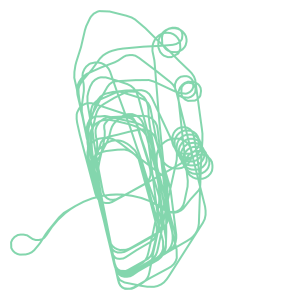

In [604]:
datas["ADA4_025"]

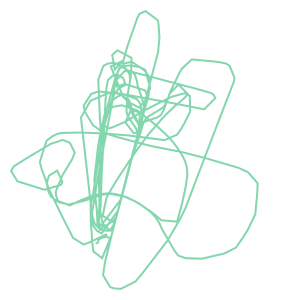

In [605]:
datas["CALIBRA_026"]

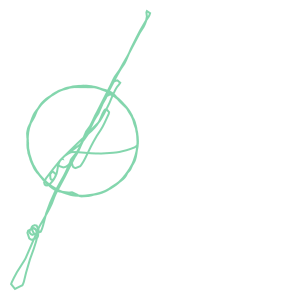

In [606]:
datas["VOR05_034"]

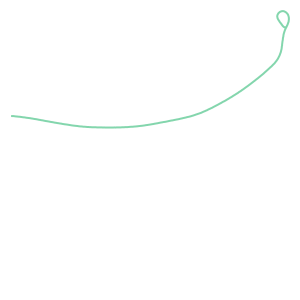

In [607]:
datas["REGA1_018"]

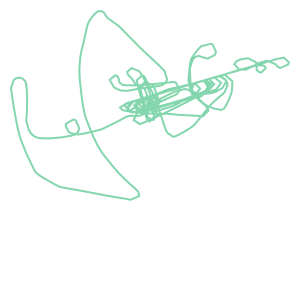

In [608]:
datas["CALIBRA_021"]

# Task 3: Plotting radar-simulated data against the original flight data to observe the difference 

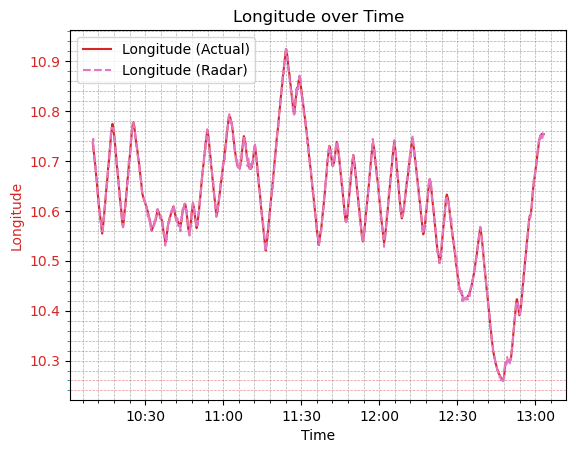

In [609]:
plot_actual_radar_longitude(actual_data, radar_data, 5, 5)

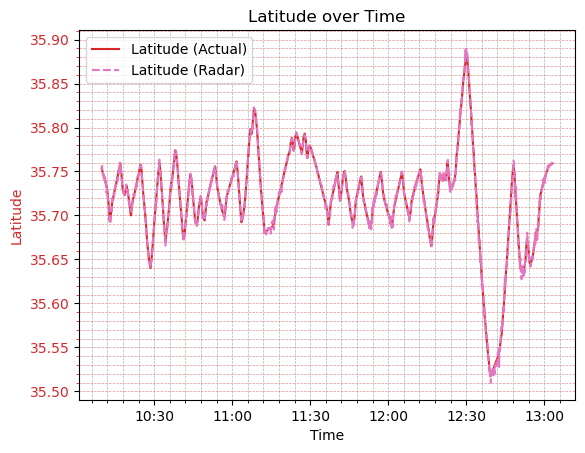

In [610]:
plot_actual_radar_latitude(actual_data, radar_data, 5, 5)

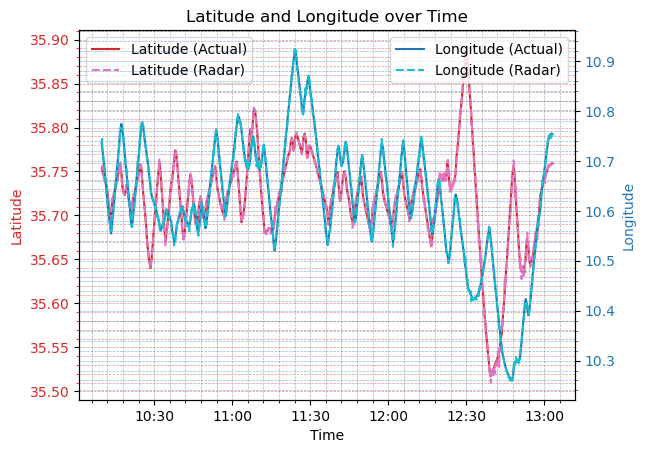

In [611]:
plot_actual_radar_all(actual_data, radar_data, 5, 5, 5)

### TASK 5: Plot filtered position estimates alongisde the original track 

Plotting filtered data against actual data

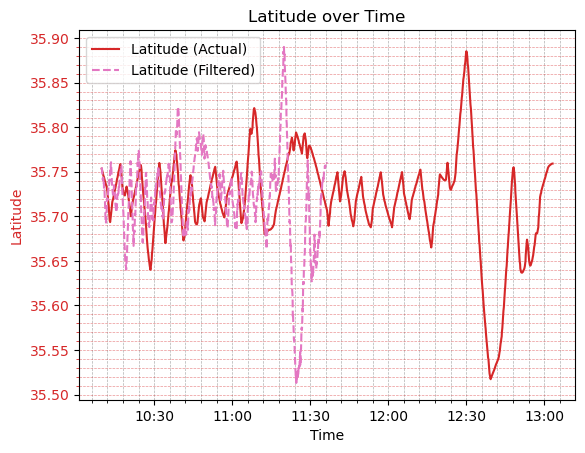

In [612]:
plot_actual_radar_latitude(actual_data, filtered_flight_data, 5, 5, radar_data_label_latitude="Latitude (Filtered)")

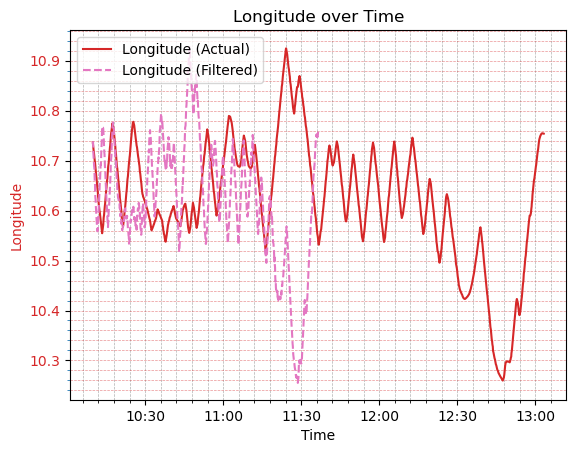

In [613]:
plot_actual_radar_longitude(actual_data, filtered_flight_data, 5, 5, radar_data_label_longitude="Longitude (Filtered)")

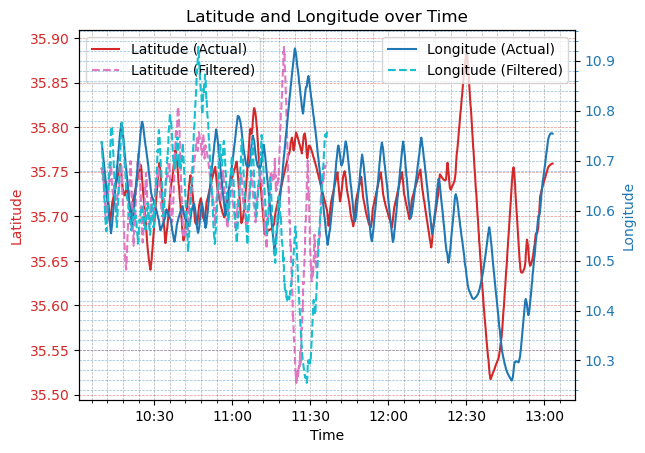

In [614]:
plot_actual_radar_all(actual_data, filtered_flight_data, 5, 5, radar_data_label_longitude= "Longitude (Filtered)", radar_data_label_latitude="Latitude (Filtered)")

## Plot filtered vs smoothed 

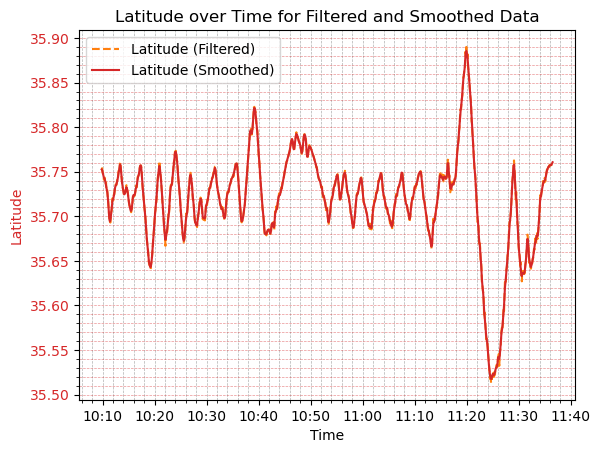

In [615]:
plot_filtered_smoothed_latitude(filtered_flight_data, smoothed_flight_data,5,5)

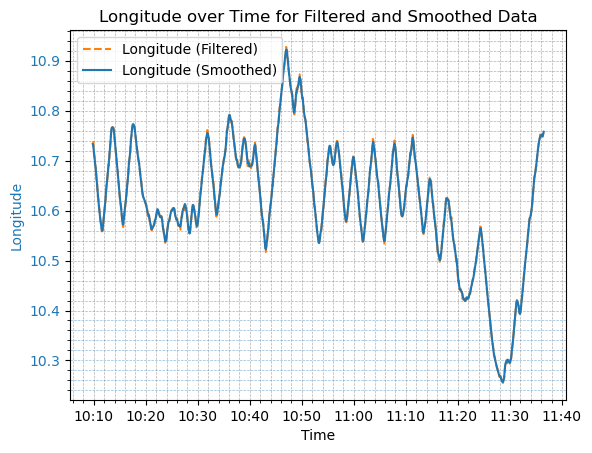

In [616]:
plot_filtered_smoothed_longitude(filtered_flight_data, smoothed_flight_data,5,5)

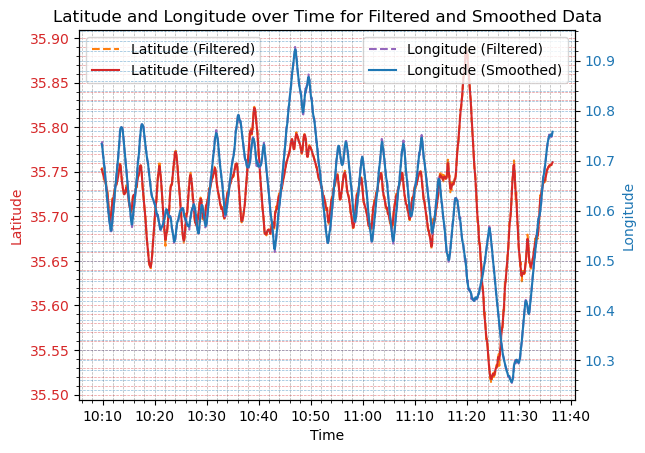

In [617]:
plot_filtered_smoothed_all(filtered_flight_data, smoothed_flight_data, 5, 5, filtered_data_label_longitude= "Longitude (Filtered)", smoothed_data_label_latitude="Latitude (Filtered)")

# Error Measurement and Model Evaluation

### Define Function for calculating mean and maximum distance

In [618]:
def calculate_mean_max_distance(data_1, data_2):
    """returns (mean distance, max distance) of two geo coordinated data.  

    Args:
        data_1 (pandas.DataFrame): DataFrame of tuples with 'latitude' and 'longitude' values
        data_2 (pandas.DataFrame): DataFrame of tuples with 'latitude' and 'longitude' values
    """
    # Initialize list to store distances
    distances = []

    # Iterate through the filtered positions and the original data
    for (data_1_lat, data_1_lon), (data_2_lat, data_2_lon) in zip(zip(data_1.latitude, data_1.longitude), zip(data_2.latitude, data_2.longitude)):
        if pd.isna(data_1_lat) or pd.isna(data_1_lon) or pd.isna(data_2_lat) or pd.isna(data_2_lon):
            continue  # Skip this pair if any NaN values are found
        # Calculate distance between filtered and original positions
        distance = dist.geodesic((data_1_lat, data_1_lon), (data_2_lat, data_2_lon)).meters  # geodesic returns the distance in meters
        distances.append(distance)

    # Compute the mean and maximal distances
    mean_distance = np.mean(distances)
    max_distance = np.max(distances)
    
    return mean_distance, max_distance

### TASK 6: Calculating the mean and max distance

In [619]:
for flight_id, results in experiment_results.items():
    actual_data = results['actual_data']
    filtered_data = results['filtered_means'] 

    mean_distance, max_distance = calculate_mean_max_distance(actual_data, filtered_data)
    
    print(f"Flight ID: {flight_id}")
    print(f"Mean Distance: {mean_distance} meters")
    print(f"Max Distance: {max_distance} meters")
    

Flight ID: ADA4_025
Mean Distance: 12409.790913344408 meters
Max Distance: 32834.58245103739 meters
Flight ID: CALIBRA_026
Mean Distance: 11037.408218567909 meters
Max Distance: 29439.97654328957 meters
Flight ID: VOR05_034
Mean Distance: 23025.88741642973 meters
Max Distance: 41452.729620602484 meters
Flight ID: REGA1_018
Mean Distance: 6114.356857524671 meters
Max Distance: 10073.673026850583 meters
Flight ID: CALIBRA_021
Mean Distance: 14957.055655969285 meters
Max Distance: 53880.99245946508 meters


Use smoothing to compute estimates for all states based on all the available data. How much
better are the smoothed tracks, compared to the filtered ones? Are there specific areas in
the flights where smoothed tracks are better?

To evaluate how much better the smoothed tracks are compared to the filtered ones, we need to compare the average and maximum distances from the actual flight path for both the filtered and smoothed estimates.    apply this function separately for the filtered and smoothed data against the actual data, then compare these values.



In [620]:
# we want to compare the accuracy of flight positions with actual flight data vs. filtered and smooth flight paths
# Initialize lists to store mean and max distances for filtered and smoothed data
filtered_distances = {'mean': [], 'max': []}
smoothed_distances = {'mean': [], 'max': []}

# Loop through each selected flight ID and calculate distances
for flight_id, results in experiment_results.items():
    actual_data = results['actual_data']
    filtered_data = results['filtered_means']
    smoothed_data = results['smoothed_means']

    # Calculate distances for filtered and smoothed data
    mean_filtered_distance, max_filtered_distance = calculate_mean_max_distance(actual_data, filtered_data)
    mean_smoothed_distance, max_smoothed_distance = calculate_mean_max_distance(actual_data, smoothed_data)

    # Store the distances
    filtered_distances['mean'].append(mean_filtered_distance)
    filtered_distances['max'].append(max_filtered_distance)
    smoothed_distances['mean'].append(mean_smoothed_distance)
    smoothed_distances['max'].append(max_smoothed_distance)

    # Print out distances for the current flight
    print(f"Flight ID: {flight_id}")
    print(f"Mean Filtered Distance: {mean_filtered_distance:.2f} meters")
    print(f"Max Filtered Distance: {max_filtered_distance:.2f} meters")
    print(f"Mean Smoothed Distance: {mean_smoothed_distance:.2f} meters")
    print(f"Max Smoothed Distance: {max_smoothed_distance:.2f} meters")
    print("-" * 50)  # Print a separator for readability

# After the loop, compute the averages across all flights
average_filtered_mean_distance = np.mean(filtered_distances['mean'])
average_filtered_max_distance = np.mean(filtered_distances['max'])
average_smoothed_mean_distance = np.mean(smoothed_distances['mean'])
average_smoothed_max_distance = np.mean(smoothed_distances['max'])

# Print out the overall averages
print("Overall Averages:")
print(f"Average Mean Distance for Filtered Data: {average_filtered_mean_distance:.2f} meters")
print(f"Average Max Distance for Filtered Data: {average_filtered_max_distance:.2f} meters")
print(f"Average Mean Distance for Smoothed Data: {average_smoothed_mean_distance:.2f} meters")
print(f"Average Max Distance for Smoothed Data: {average_smoothed_max_distance:.2f} meters")


Flight ID: ADA4_025
Mean Filtered Distance: 12409.79 meters
Max Filtered Distance: 32834.58 meters
Mean Smoothed Distance: 12392.07 meters
Max Smoothed Distance: 32714.53 meters
--------------------------------------------------
Flight ID: CALIBRA_026
Mean Filtered Distance: 11037.41 meters
Max Filtered Distance: 29439.98 meters
Mean Smoothed Distance: 11022.86 meters
Max Smoothed Distance: 29029.14 meters
--------------------------------------------------
Flight ID: VOR05_034
Mean Filtered Distance: 23025.89 meters
Max Filtered Distance: 41452.73 meters
Mean Smoothed Distance: 23018.04 meters
Max Smoothed Distance: 41295.52 meters
--------------------------------------------------
Flight ID: REGA1_018
Mean Filtered Distance: 6114.36 meters
Max Filtered Distance: 10073.67 meters
Mean Smoothed Distance: 6112.25 meters
Max Smoothed Distance: 10026.48 meters
--------------------------------------------------
Flight ID: CALIBRA_021
Mean Filtered Distance: 14957.06 meters
Max Filtered Dista

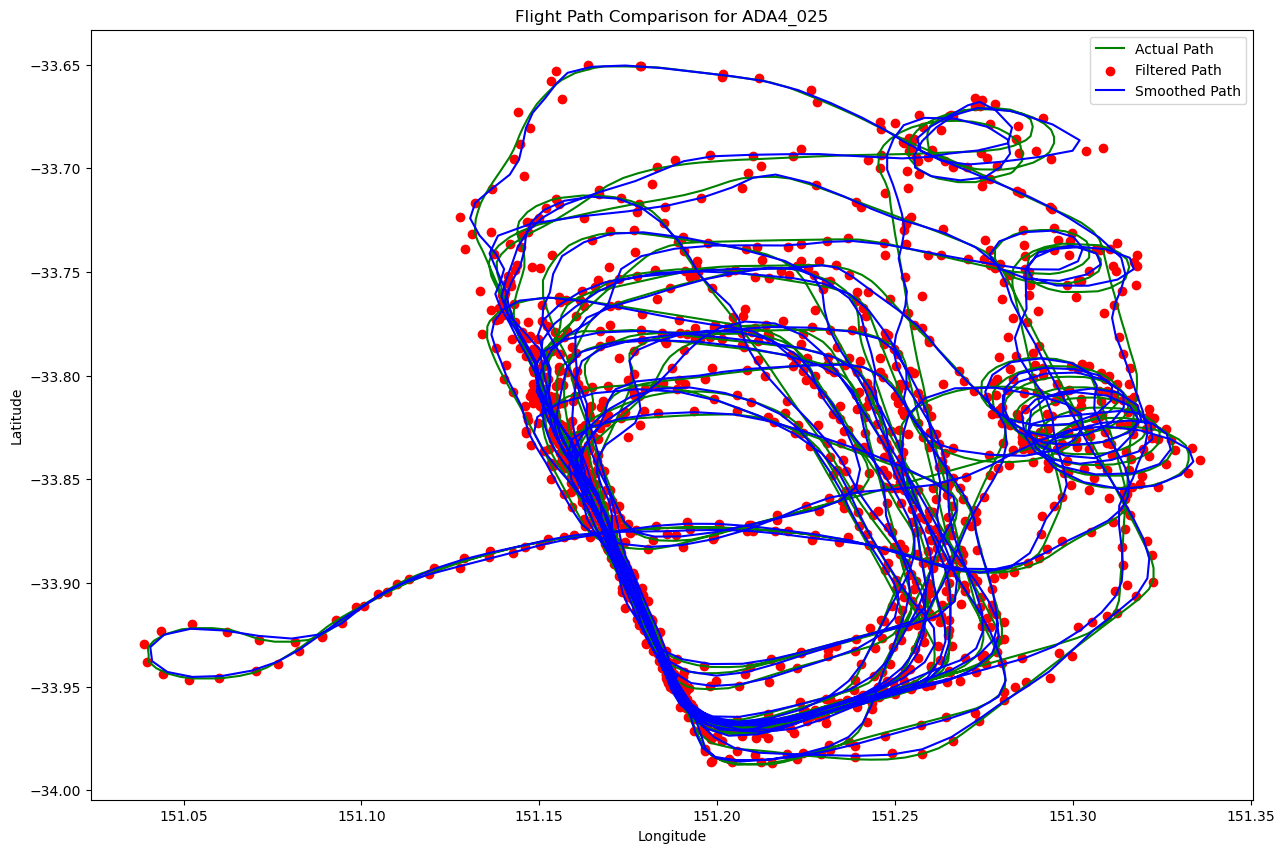

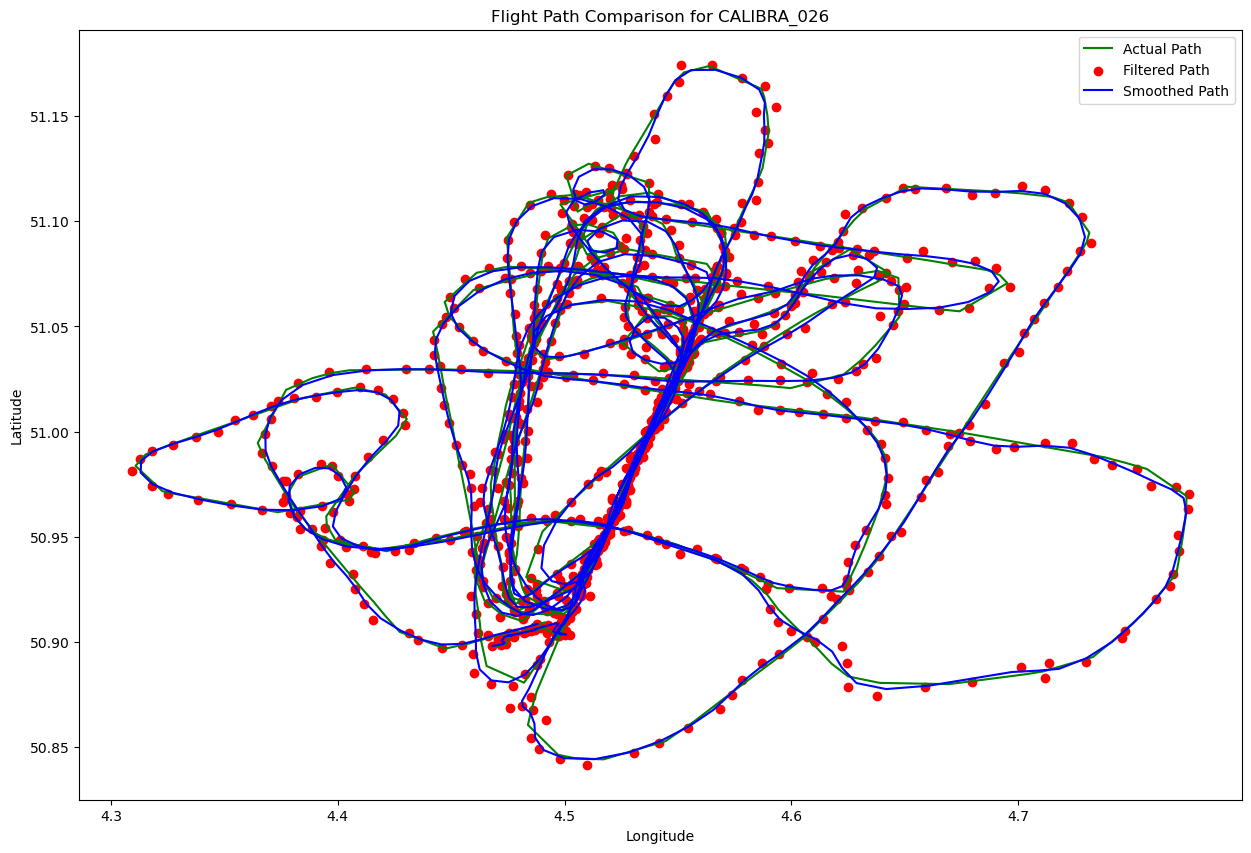

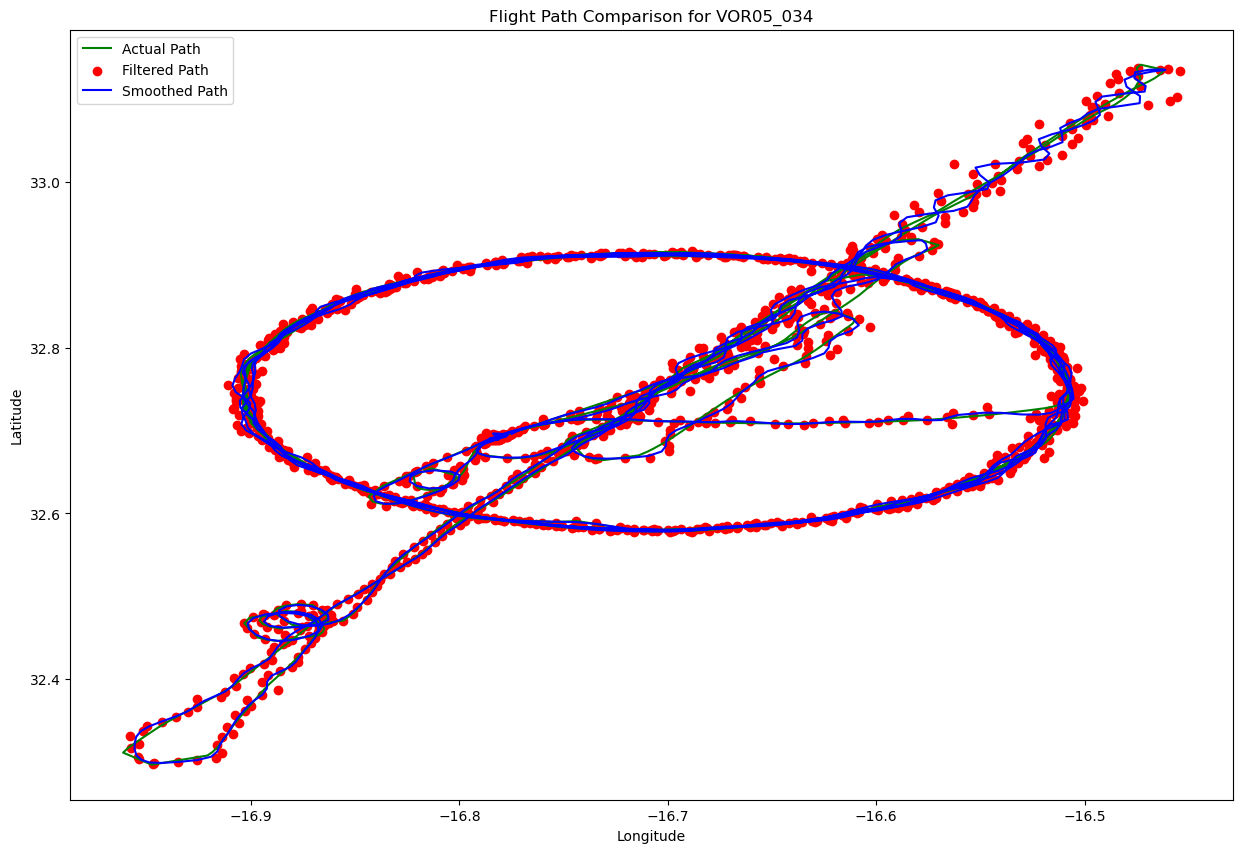

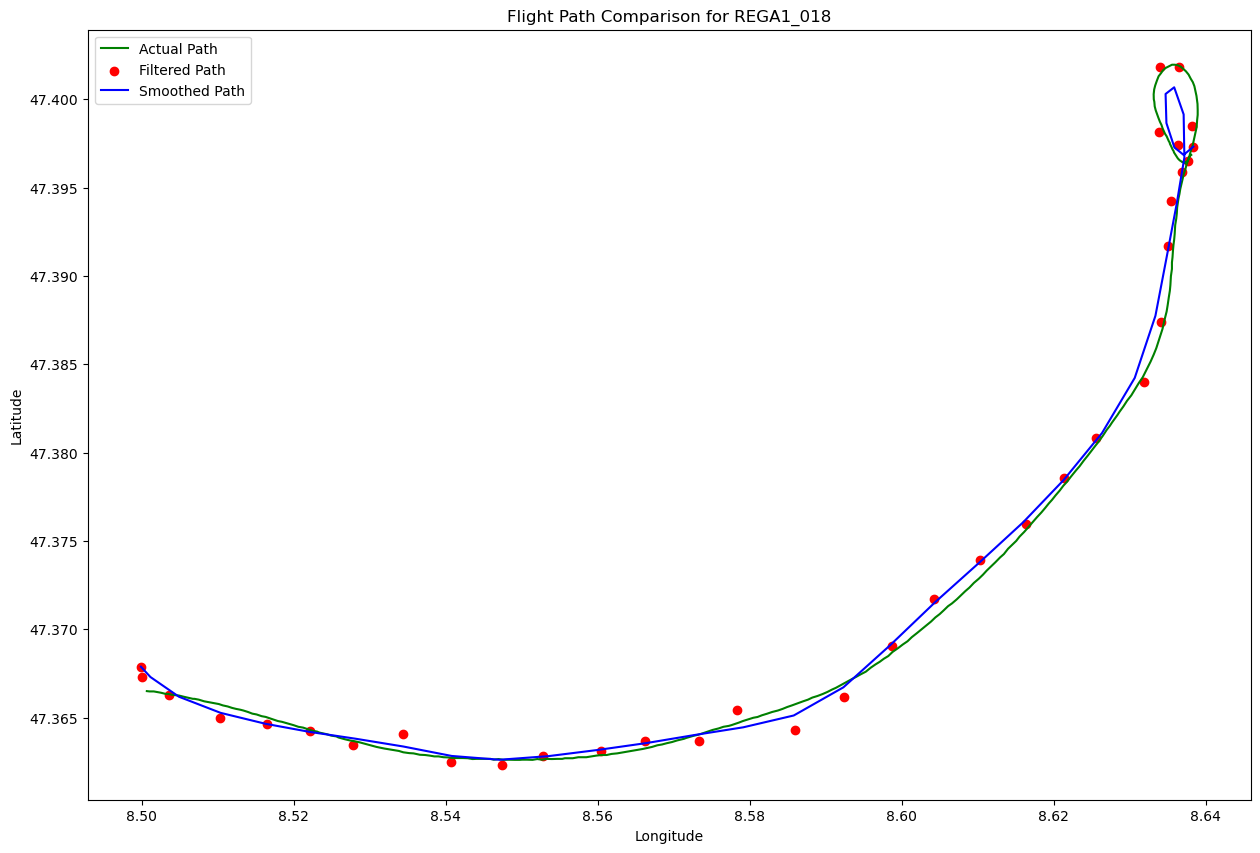

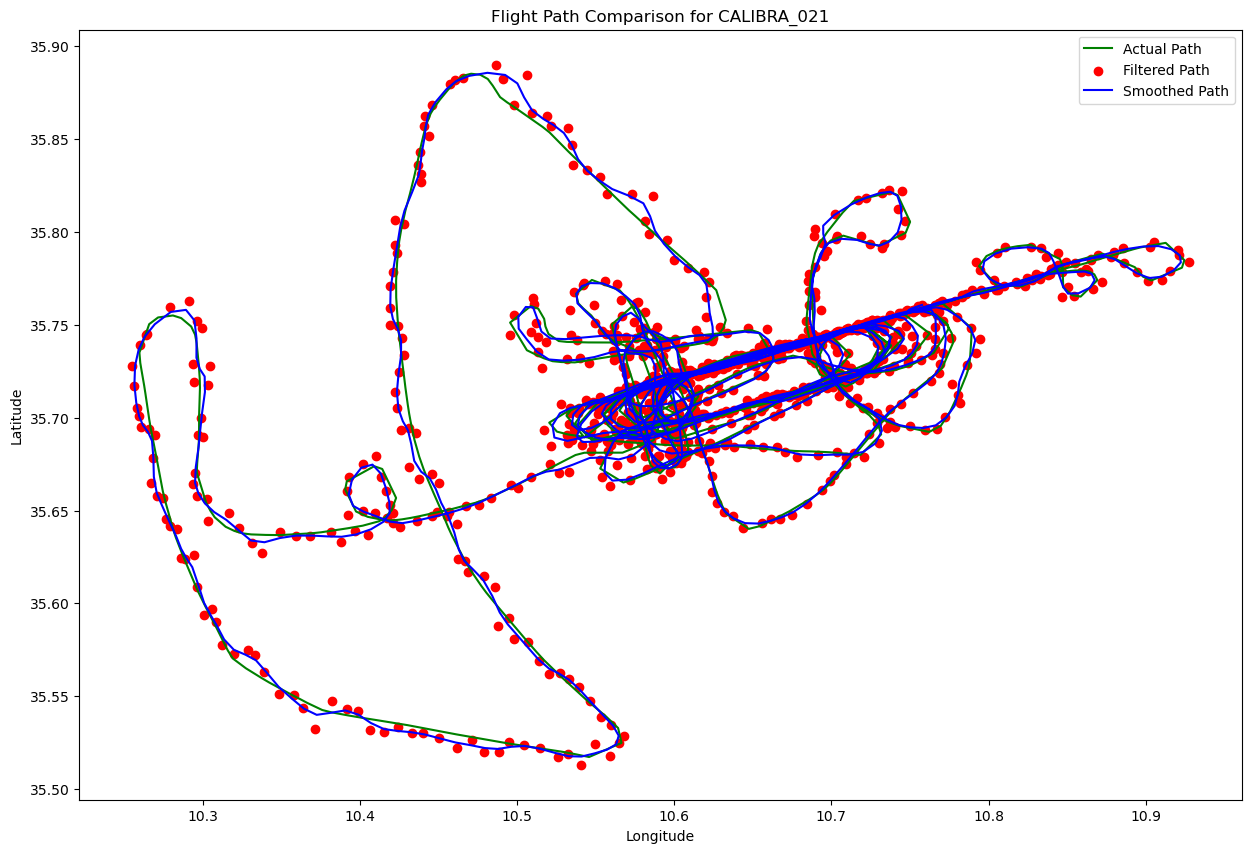

In [621]:
# Plotting the comparison for the flights in selected_flight_ids
for flight_id in selected_flight_ids: 
    actual_data = experiment_results[flight_id]['actual_data']
    filtered_data = experiment_results[flight_id]['filtered_means']
    smoothed_data = experiment_results[flight_id]['smoothed_means']
    
    plt.figure(figsize=[15, 10])
    plt.plot(actual_data['longitude'], actual_data['latitude'], 'g-', label='Actual Path')
    plt.scatter(filtered_data['longitude'], filtered_data['latitude'], c='r', marker='o', label='Filtered Path')
    plt.plot(smoothed_data['longitude'], smoothed_data['latitude'], 'b-', label='Smoothed Path')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title(f"Flight Path Comparison for {flight_id}")
    plt.show()


# Task 8: Experiments for process noise and observation noise

In [622]:
def calculate_mean_max_distance_flightData(flight_data, process_noise, observation_noise):
    """
    Calculates the mean and max distance errors between the filtered flight data 
    and the actual flight data after applying a Kalman filter with specified noise levels.

    Args:
        flight_data (Flight): Flight object containing actual flight information.
        process_noise (float): Process noise level for the Kalman filter.
        observation_noise (float): Observation noise level for the Kalman filter.

    Returns:
        tuple: Mean and maximum distance errors.
    """
    
    # Actual flight data within the specified time range
    actual_data = flight_data.data

    # Ensure the flight exists and has data
    if flight is None or flight.data.empty:
        print(f"Skipping flight {flight_id} due to missing or empty data.")
        return None
            
    # Generate radar data for the same time range and ensure it exists
    radar_data = get_radar_data_for_flight(flight).data
    if radar_data.empty:
        print(f"Skipping flight {flight_id} due to lack of radar data.")
        return None

    # Construct the Kalman filter model with specified noise levels
    kf = construct_kalman_filter(radar_data, 10, process_noise, observation_noise)

    # Extract measurements (x and y positions from radar data)
    measurements = np.column_stack((radar_data.x, radar_data.y))

    # Apply Kalman filter on measurements
    filtered_state_means, filtered_state_covariances = kf.filter(measurements)

    if len(radar_data) == len(filtered_state_means):
        # Create a deep copy of the flight data to avoid altering the original
        filtered_flight_data = deepcopy(flight.data)

        # Update 'x', 'y' in the deep copy based on filtered values
        for idx, _ in enumerate(filtered_state_means):
            if idx in flight.data.index:
                # Update for filtered states
                filtered_flight_data.at[idx, 'x'] = filtered_state_means[idx, 0]
                filtered_flight_data.at[idx, 'y'] = filtered_state_means[idx, 1]

        # Convert updated x, y back to lat, lon for filtered data
        filtered_flight = deepcopy(flight)
        filtered_flight.data = filtered_flight_data
        set_lat_lon_from_x_y(filtered_flight)
   
    # Calculate mean and max distance between actual data and filtered data
    return calculate_mean_max_distance(actual_data, filtered_flight.data)

In [623]:
def calculate_avg_mean_max_error_flights(flights, process_noise, observation_noise):
    """This function takes in an array of flight data and calculates the mean and max errors in
    for a particular process noise and observation noise.
    Returns a tuple (mean of accumulated mean error, mean of accumulated max error)

    Args:
        flights (Array[tuple<flight traffic.core.flight.Flight, start_time string, end_time string]): Array of flight datas to be used for average calculations 
        process_noise (integer): Noise for process
        observation_noise (integer): Noise for observation
    """
    accumulated_mean = []
    accumulated_max = []
    
    for flight in flights:
        mean, max_error = calculate_mean_max_distance_flightData(flight, 
                                                                 process_noise, observation_noise)
        accumulated_mean.append(mean)
        accumulated_max.append(max_error)
    
    return (np.mean(accumulated_mean), np.mean(accumulated_max))
    

In [628]:
def plot_noise_tables(flights,
                      initial_observation_noise_value, final_observation_noise_value, 
                      initial_process_noise_value, final_process_noise_value,
                      observation_interval=10, process_interval=0.5):
    """This function takes in an array of flight datas and plots the average mean and max values of
    based on the different combinations of noise values from initial_noise_value to the final_noise_value 
    in intervals of defined by observation_interval and process_interval for observation noise and process
    noise respectively.

    Args:
        flights (Array[traffic.core.flight.Flight]): List of flights to be used for the data sampling
        initial_observation_noise_value (double): Initial noise value for observation  
        final_observation_noise_value (double): Final noise value for observation
        initial_process_noise_value (double): Initial noise value for process
        final_process_noise_value (double): Final noise value for process
        observation_interval (double): Observation noise sampling interval
        process_interval (double): Process noise sampling interval
    """

    mean_data_to_plot = []
    max_data_to_plot = []
    observation_noise = initial_observation_noise_value
    process_noise = initial_process_noise_value
    
    while process_noise <= final_process_noise_value:
        row_mean = []
        row_max = []
        while observation_noise <= final_observation_noise_value:
            mean, max_error = calculate_avg_mean_max_error_flights(flights, process_noise, observation_noise)
            row_mean.append(mean)
            row_max.append(max_error)
            if (observation_noise == 100 and process_noise == 1.5):
                print(mean, max_error)
            observation_noise += observation_interval
        mean_data_to_plot.append(row_mean)
        max_data_to_plot.append(row_max)
        
        observation_noise = initial_observation_noise_value
        process_noise += process_interval
    
    mean_data_array = np.array(mean_data_to_plot)
    max_data_array = np.array(max_data_to_plot)
    
    # Generating the axis labels
    observation_noise_labels = np.arange(initial_observation_noise_value, final_observation_noise_value + observation_interval, observation_interval)
    process_noise_labels = np.arange(initial_process_noise_value, final_process_noise_value + process_interval, process_interval)
    
    # Adjust the plot for mean_data
    plt.figure(figsize=(10, 8))
    plt.imshow(mean_data_array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Mean Error')
    plt.xlabel('Observation Noise')
    plt.ylabel('Process Noise')

    # Setting the axis ticks to match the labels
    plt.xticks(ticks=np.arange(len(observation_noise_labels)), labels=[f"{label:.2f}" for label in observation_noise_labels])
    plt.yticks(ticks=np.arange(len(process_noise_labels)), labels=[f"{label:.2f}" for label in process_noise_labels])

    plt.title('Mean Data Plot')
    plt.show()

    # Adjust the plot for max_data
    plt.figure(figsize=(10, 8))
    plt.imshow(max_data_array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Max Error')
    plt.xlabel('Observation Noise')
    plt.ylabel('Process Noise')

    # Setting the axis ticks to match the labels
    plt.xticks(ticks=np.arange(len(observation_noise_labels)), labels=[f"{label:.2f}" for label in observation_noise_labels])
    plt.yticks(ticks=np.arange(len(process_noise_labels)), labels=[f"{label:.2f}" for label in process_noise_labels])

    plt.title('Max Data Plot')
    plt.show()

In [629]:
# Collect the selected flights into a list for analysis
flights = [datas[flight_id] for flight_id in selected_flight_ids if flight_id in datas]
print(flights)

# Print out the selected flights 
print("Selected flights for analysis:")
for flight in flights:
    print(flight)


[Flight('ADA4_025', icao24='7c1a89', callsign='ADA4'), Flight('CALIBRA_026', icao24='39b415', callsign='CALIBRA'), Flight('VOR05_034', icao24='4070f4', callsign='VOR05'), Flight('REGA1_018', icao24='4b43ac', callsign='REGA1'), Flight('CALIBRA_021', icao24='39b415', callsign='CALIBRA')]
Selected flights for analysis:
Flight('ADA4_025', icao24='7c1a89', callsign='ADA4')
Flight('CALIBRA_026', icao24='39b415', callsign='CALIBRA')
Flight('VOR05_034', icao24='4070f4', callsign='VOR05')
Flight('REGA1_018', icao24='4b43ac', callsign='REGA1')
Flight('CALIBRA_021', icao24='39b415', callsign='CALIBRA')


flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021
flight: CALIBRA_021


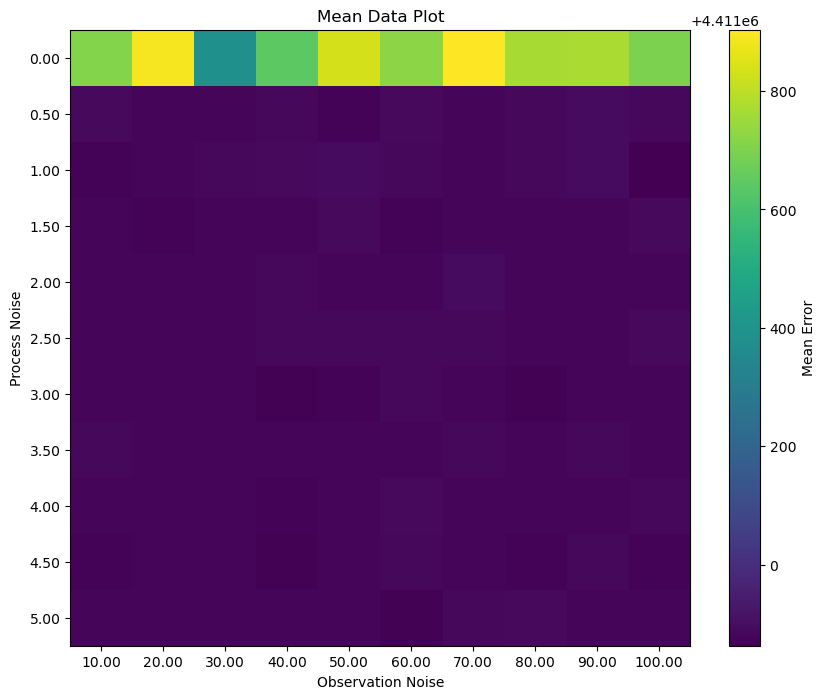

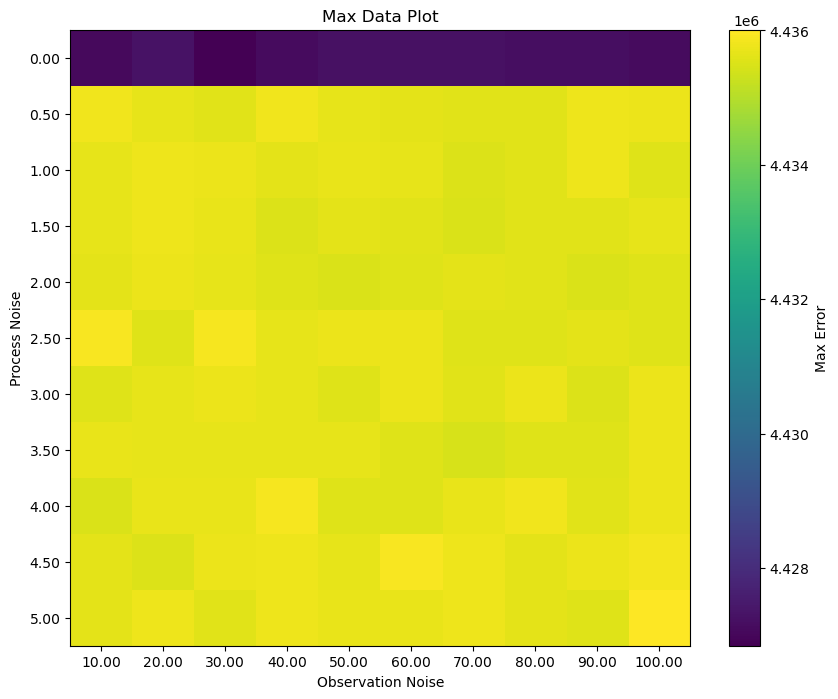

In [630]:
plot_noise_tables(flights, 10, 100, 0, 5, 10, 0.5)

# Task 10

In [633]:
def construct_kalman_filter3D(data, delta_time=10):
    """Takes the radar data and defines the 3D kalman filter model for the radar model with altitude involved

    Args:
        data (traffic.core.flight.Flight): The flight data to be used for the construction of the Kalman Filter model
        delta_time (int, optional): The time between each sampling. Defaults to 10.
    """

    radar_data = data.data
    dim_x = 6
    dim_z = 3
    standard_deviation_process = 1.5  # Standard Deviation for acceleration  (Plane example)
    standard_deviation_observation = 100  # Standard Deviation for radar measurement

    # Initialize the Kalman Filter
    kf = KalmanFilter(dim_x, dim_z)

    # Define the initial state estimate
    initial_position = np.array([radar_data.x.iloc[0], radar_data.y.iloc[0], radar_data.z.iloc[0], 0., 0., 0.]) # Assuming initial velocity is 0
    kf.initial_state_mean = initial_position

    # Define the state transition matrix (F)
    kf.transition_matrices = np.array(
                    [[1, 0, 0, delta_time, 0, 0],
                    [0, 1, 0, 0, delta_time, 0],
                    [0, 0, 1, 0, 0, delta_time],
                    [0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1]])

    # Define the process noise covariance matrix (Q)

    a = (1/4 * delta_time**4) * (standard_deviation_process**2)
    b = (1/2 * delta_time**3) * (standard_deviation_process**2)
    c = delta_time**2 * (standard_deviation_process**2)
    kf.transition_covariance = np.array(
                    [[a, 0, 0, b, 0, 0],
                    [0, a, 0, 0, b, 0],
                    [0, 0, a, 0, 0, b],
                    [b, 0, 0, c, 0, 0],
                    [0, b, 0, 0, c, 0],
                    [0, 0, b, 0, 0, c]])

    # Define the observation matrix (H)
    kf.observation_matrices = np.array([[1, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0]]) 

    # Define the measurement noise covariance matrix (R)
    kf.observation_covariance = np.array([[standard_deviation_observation**2, 0, 0],
                    [0, standard_deviation_observation**2, 0],
                    [0, 0, standard_deviation_observation**2]])    
    
    return kf